In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import sys
import os
from astropy.table import Table
from astropy.io import fits, ascii
import GCRCatalogs
from scipy.optimize import curve_fit
from scipy.special import erf

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from plotting_functions import *

from clevar.catalog import ClCatalog
from clevar.match_metrics.recovery import ClCatalogFuncs as r_cf
from clevar.match_metrics import recovery
from clevar.match import output_matched_catalog

import pyccl as ccl

In [ ]:
from tqdm.notebook import tqdm

## No files are being written to folders from this notebook.
The directory construction is only for troubleshooting purposes.
The corresponding files are written to the directories from the python script version of this notebook.

In [ ]:
catstr1 = 'wazp_cosmoDC2_v0'
catstr2 = 'wazp_cosmoDC2.fzb_v0'
mm = 'membership'

In [ ]:
cats = [catstr1.split('_'), catstr2.split('_')]
matching_method = mm

In [ ]:
(first, last) = np.argsort([c[0] for c in cats])

In [ ]:
area = [440 if 'cosmoDC2' in c else 300 if 'DC2' in c else None for c in (catstr1, catstr2)]

In [ ]:
## EXAMPLE INPUT: cosmoDC2_v1 wazp_cosmoDC2.fzb_v0 proximity
## RESULTING INPATH: /cosmoDC2_wazp.cosmoDC2.fzb/v1_v0/
inpath = inpath = '/sps/lsst/groups/clusters/cluster_comparison_project/after_matching/'
inpath += f"{'.'.join(cats[first][:-1])}_{'.'.join(cats[last][:-1])}/"
inpath += f"{cats[first][-1]}_{cats[last][-1]}/"
if matching_method == 'proximity' :
        inpath += 'proximity_matching_deltaz_0.05_matchradius_1mpc/'
else :
        inpath += 'member_matching_fshare_0.0/'

outpath = '/sps/lsst/users/rsolomon/web/desc/cluster_comparison_project/'
outpath += f"{'.'.join(cats[first][:-1])}_{'.'.join(cats[last][:-1])}/"
outpath += f"{cats[first][-1]}_{cats[last][-1]}/"
if matching_method == 'proximity' :
        outpath += 'proximity_matching_deltaz_0.05_matchradius_1mpc/'
else :
        outpath += 'member_matching_fshare_0.0/'

### Read in matched catalogs.

In [ ]:
cl = []
for c in cats :
    cl.append(Table(fits.open(inpath + '.'.join(c) + '.fits')[1].data))

If catalogs exist, make (print) corresponding plot directories.

In [ ]:
outpaths = [f'{outpath}png_plots/', f'{outpath}pdf_plots/']
for path in outpaths :
    if not os.path.exists(path) :
        ##os.makedirs(path)
        print(f'{path} DOES NOT EXIST')
    else :
        print(f'{path} EXISTS')

Only look at those clusters that have been cross matched.

In [ ]:
cl[0].sort('mt_cross')
cl[1].sort('id_cl')

matches = [cl[0]['mt_cross'] != '', cl[1]['mt_cross'] != '']

Use a consistent color scheme.

In [ ]:
colors = {'cosmoDC2':'black',
          'cosmoDC2.fzb':'gray',
          'wazp':'C0',
          'redmapper':'red'}

In [ ]:
linestyle = ('-','--') if cats[0][0]==cats[1][0] else ('-','-')

### Plot on sky

In [ ]:
for i in range(len(cl)) :
    plot_on_sky(cl[i]['ra_cl'], cl[i]['dec_cl'], alpha=0.2, title=f"{'.'.join(cats[i][:-1])}",
                label=('halos' if cats[i][0]=='cosmoDC2' else 'clusters'), show=True);

In [ ]:
plot_on_sky(cl[0]['ra_cl'][matches[0]], cl[0]['dec_cl'][matches[0]], alpha=0.2,
            title=f"{'.'.join(cats[first][:-1])}-{'.'.join(cats[last][:-1])}",
            label=('cl-halo matches' if ('cosmoDC2' in (cats[0][0],cats[1][0])) else 'cl-cl matches'), show=True);

In [ ]:
plt.hist(np.sqrt((cl[0]['ra_cl'][matches[0]]-cl[1]['ra_cl'][matches[1]])**2 + (cl[0]['dec_cl'][matches[0]]-cl[1]['dec_cl'][matches[1]])**2), bins='scott', histtype='step');

## Plot redshift stuff

First, redshift histograms.

In [ ]:
fill = False
if cats[0][0] == cats[1][0] :
    fill = True
    
if np.any([c[0] == 'cosmoDC2' for c in cats]) :
    annotate = 'clusters/halos'
else :
    annotate = 'clusters'

    
fig = plt.subplots(1,1, figsize=(3.5,3.5))
fig[1].ticklabel_format(axis='both', style='scientific', scilimits=[-2,2])

bin_width=0.05
plot_redshift_hist(cl[0]['z_cl'], bin_width=bin_width, fill=fill, color=colors[cats[0][0]],
                   label=f"{'.'.join(cats[0][:-1])}",
                   only_layer=False, fig=fig, last_layer=False)
plot_redshift_hist(cl[1]['z_cl'], bin_width=bin_width,  fill=False, color=colors[cats[1][0]],
                   label=f"{'.'.join(cats[1][:-1])}", annotate=annotate,
                   only_layer=False, fig=fig, show=True)

In [ ]:
fig = plt.subplots(1,1, figsize=(3.5,3.5))
plot_redshift_hist(cl[0]['z_cl'][matches[0]], fill=fill, color=colors[cats[0][0]], label=f"{'.'.join(cats[0][:-1])}",
                   only_layer=False, fig=fig, last_layer=False)
plot_redshift_hist(cl[1]['z_cl'][matches[1]], fill=False, color=colors[cats[1][0]], label=f"{'.'.join(cats[1][:-1])}", title=f"Matching: {mm}", annotate=annotate,
                   only_layer=False, fig=fig, show=True)

Second, z1 vs z2 hexbin.

In [ ]:
if np.any([c[0] == 'cosmoDC2' for c in cats]) :
    index = np.argwhere(np.array([c[0] == 'cosmoDC2' for c in cats]))[0][0]
    xs = cl[index]['z_cl'][matches[index]]
    xlabel = "$z_{true}$"
    ys = cl[-(index+1)]['z_cl'][matches[-(index+1)]]
    ylabel = f"$z_{{{'.'.join(cats[-(index+1)][:-1])}}}$"
else :
    xs = cl[0]['z_cl'][matches[0]]
    xlabel = f"$z_{{{'.'.join(cats[0][:-1])}}}$"
    ys = cl[1]['z_cl'][matches[1]]
    ylabel = f"$z_{{{'.'.join(cats[1][:-1])}}}$"
plot_redshift_zVSz(xs, ys, xlabel=xlabel, ylabel=ylabel, title=f"Matching: {mm}", diagonal=True, show=True)


Third, plot bias and std between catalog redshifts.

In [ ]:
if np.any([c[0] == 'cosmoDC2' for c in cats]) :
    index = np.argwhere(np.array([c[0] == 'cosmoDC2' for c in cats]))[0][0]
    xs = cl[index]['z_cl'][matches[index]]
    xlabel = "$z_{true}$"
    ys = cl[-(index+1)]['z_cl'][matches[-(index+1)]]
    ylabel = f"$z_{{cats[-(index+1)]}}$"
    title=f"{'.'.join(cats[index][:-1])}-{'.'.join(cats[-(index+1)][:-1])}"

    plot_redshift_std_and_mean(xs, ys, title=title)


## Now plot mass and richness stuff

In [ ]:
if np.any([c[0] == 'wazp' for c in cats]) :
    index = np.argwhere(np.array([c[0] == 'wazp' for c in cats]))[0][0]
    

In [ ]:
if np.any([c[0] == 'cosmoDC2' for c in cats]) :
    index = np.argwhere(np.array([c[0] == 'cosmoDC2' for c in cats]))[0][0]
    xs = cl[index]['log10_mass'][matches[index]]
    xlabel = '$\log M_{200c}$'
    ys = np.log10(cl[-(index+1)]['mass'][matches[-(index+1)]])
    ylabel = f"$\log \lambda_{{{'.'.join(cats[-(index+1)][:-1])}}}$"
    saveas = f"{'.'.join(cats[first])}_{'.'.join(cats[last])}_MATCHED_HALO_MASS_VS_CLUSTER_RICHNESS"
    title=f"{'.'.join(cats[first][:-1])}-{'.'.join(cats[last][:-1])}"
    plot_richness_mass(xs, ys, xlabel=xlabel, ylabel=ylabel, label=True, title=title, fit=True)
else :
    xs = np.log10(cl[first]['mass'][matches[first]])
    xlabel = f"$\log \lambda_{{{'.'.join(cats[first][:-1])}}}$"
    ys = np.log10(cl[last]['mass'][matches[last]])
    ylabel = f"$\log \lambda_{{{'.'.join(cats[last][:-1])}}}$"
    saveas = f"{'.'.join(cats[first])}_{'.'.join(cats[last])}_MATCHED_CLUSTER_RICHNESS_VS_RICHNESS"
    title=None
    plot_richness_richness(xs, ys, xlabel=xlabel, ylabel=ylabel, label=True, title=title, fit=True)

In [ ]:
def richness_mass_relation(x, c0, c1, c2) :
    return 0.5*c0*((x-c1)*erf(x-c1) + 1/np.sqrt(np.pi)*np.exp(-(x-c1)**2) + (x-c1)) + c2

def richness_richness_relation(x, c0, c1) :
    return c0 + c1*x

In [ ]:
if np.any([c[0] == 'cosmoDC2' for c in cats]) :
    index = np.argwhere(np.array([c[0] == 'cosmoDC2' for c in cats]))[0][0]
    
    redshift_bins = np.linspace(0, max(cl[index][matches[index]]['z_cl']), 3)
    
    params = [curve_fit(richness_mass_relation, cl[index]['log10_mass'][matches[index]][(cl[index]['z_cl'][matches[index]]>redshift_bins[i]) & (cl[index]['z_cl'][matches[index]]<=redshift_bins[i+1])],
                   np.log10(cl[-(index+1)]['mass'][matches[-(index+1)]][(cl[index]['z_cl'][matches[index]]>redshift_bins[i]) & (cl[index]['z_cl'][matches[index]]<=redshift_bins[i+1])]),
                   bounds=((0.5,12,0),(5,15,2))) for i in range(len(redshift_bins)-1)]
    perrs = [np.sqrt(np.diag(ps[1])) for ps in params]
    
    fig, axs = plt.subplots(1,len(redshift_bins)-1, figsize=(3.5*(len(redshift_bins)-1),3.5), sharey=True, sharex=True);
    title=f"{'.'.join(cats[first][:-1])}-{'.'.join(cats[last][:-1])}"
    fig.text(0,0, title, va='baseline', ha='left', size='small');
    Nhex = 30
    for i in range(len(redshift_bins)-1) :
        x4plot = np.linspace(13,16,100)
        zs_in_bin = (cl[index]['z_cl'][matches[index]]>redshift_bins[i]) & (cl[index]['z_cl'][matches[index]]<=redshift_bins[i+1])
        
        axs[i].plot(x4plot, richness_mass_relation(x4plot, *params[i][0]), lw=1, c='r');
        axs[i].plot(x4plot, params[i][0][0]*(x4plot - params[i][0][1]) + params[i][0][2], lw=1, c='r', ls='--', label='$\lambda \propto M_{{200c}}^{{{{{:.2f}}} \pm {{{:.2f}}}}}$'.format(params[i][0][0], perrs[i][0]));
        axs[i].hexbin(cl[index]['log10_mass'][matches[index]][zs_in_bin],
                      np.log10(cl[-(index+1)]['mass'][matches[-(index+1)]][zs_in_bin]),
                      gridsize=(int(Nhex*hex_w),int(Nhex*hex_h)), norm=mpl.colors.LogNorm(), edgecolors='none');

        axs[i].set_ylim(0.25,2.5);
        axs[i].set_xlim(13,15.5);
        if i == 0 :
            axs[i].set_ylabel(f"$\log \lambda_{{{'.'.join(cats[-(index+1)][:-1])}}}$", loc='top');
        axs[i].set_xlabel('$\log M_{200c}$', loc='right');
        axs[i].annotate(f'${{{redshift_bins[i]:.1f}}} < z_{{cl}} \leq {{{redshift_bins[i+1]:.1f}}}$', xy=(axs[i].axis()[0], axs[i].axis()[3]), xycoords='data', va='top', ha='left', bbox=dict(boxstyle='round', fc='w', lw=1));
        axs[i].legend(loc='lower right', frameon=False);    

In [ ]:
if not np.any([c[0] == 'cosmoDC2' for c in cats]) :
    index = first
    redshift_bins = np.linspace(0, max(cl[index][matches[index]]['z_cl']), 5)
    
    params = [curve_fit(richness_richness_relation, np.log10(cl[index]['mass'][matches[index]][(cl[index]['z_cl'][matches[index]]>redshift_bins[i]) & (cl[index]['z_cl'][matches[index]]<=redshift_bins[i+1])]),
                   np.log10(cl[-(index+1)]['mass'][matches[-(index+1)]][(cl[index]['z_cl'][matches[index]]>redshift_bins[i]) & (cl[index]['z_cl'][matches[index]]<=redshift_bins[i+1])]),
                   bounds=((0,-2),(2,10))) for i in range(len(redshift_bins)-1)]
    perrs = [np.sqrt(np.diag(ps[1])) for ps in params]
    
    fig, axs = plt.subplots(1,len(redshift_bins)-1, figsize=(3.5*(len(redshift_bins)-1),3.5), sharey=True, sharex=True);
    title=f"{'.'.join(cats[first][:-1])}-{'.'.join(cats[last][:-1])}"
    fig.text(0,0, title, va='baseline', ha='left', size='small');
    Nhex = 30
    for i in range(len(redshift_bins)-1) :
        x4plot = np.linspace(0,4,100)
        zs_in_bin = (cl[index]['z_cl'][matches[index]]>redshift_bins[i]) & (cl[index]['z_cl'][matches[index]]<=redshift_bins[i+1])
        
        axs[i].plot(x4plot, richness_richness_relation(x4plot, *params[i][0]), lw=1, c='r', label='$\lambda_| = \lambda_{{-}}^{{\left({:.2f} \pm {:.2f}\\right)}} 10^{{\left({:.2f} \pm {:.2f}\\right)}} $'.format(params[i][0][1],perrs[i][1],params[i][0][0], perrs[i][0]));
        axs[i].hexbin(np.log10(cl[index]['mass'][matches[index]][zs_in_bin]),
                      np.log10(cl[-(index+1)]['mass'][matches[-(index+1)]][zs_in_bin]),
                      gridsize=(int(Nhex*hex_w),int(Nhex*hex_h)), norm=mpl.colors.LogNorm(), edgecolors='none');
        axs[i].set_ylim(0.25,3);
        axs[i].set_xlim(0.5,3);
        if i == 0 :
            axs[i].set_ylabel(f"$\log \lambda_{{{'.'.join(cats[-(index+1)][:-1])}}}$", loc='top');
        axs[i].set_xlabel(f"$\log \lambda_{{{'.'.join(cats[index][:-1])}}}$", loc='right');
        axs[i].annotate(f'${{{redshift_bins[i]:.1f}}} < z_{{cl(-)}} \leq {{{redshift_bins[i+1]:.1f}}}$', xy=(axs[i].axis()[0], axs[i].axis()[3]), xycoords='data', va='top', ha='left', bbox=dict(boxstyle='round', fc='w', lw=1));
        axs[i].legend(loc='lower right', frameon=True);

## Density stuff

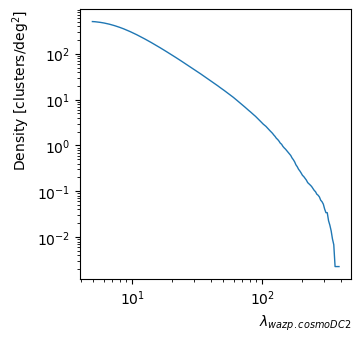

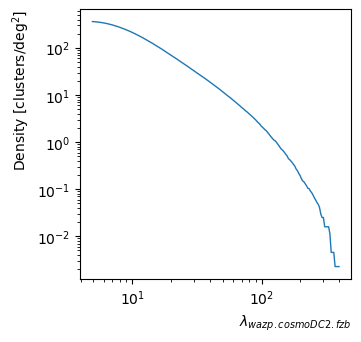

In [244]:
density = [[np.sum(cl[i]['mass'] > x)/area[i] for x in np.logspace(0,3,300)] for i in range(2)]

start_i = np.array([np.nonzero(np.diff(density[i]))[0][0] for i in range(2)])
last_i = np.array([np.nonzero(density[i])[0][-1] for i in range(2)])

for i in range(2) :
    fig = plt.subplots(1,1, figsize=(3.5,3.5));
    if np.any([c[0] == 'cosmoDC2' for c in cats]) :
        xs = np.logspace(13,17,300)
        xlabel = '$M_{200c}$'
        ylabel = 'Density [halos/deg$^2$]'
    else :
        xs = np.logspace(0,3,300)
        xlabel = f"$\lambda_{{{'.'.join(cats[i][:-1])}}}$"
        ylabel = r'Density [clusters/deg$^2$]'
    
    fig[1].plot(xs[start_i[i]:last_i[i]], density[i][start_i[i]:last_i[i]], lw=1, c=colors[cats[i][0]]);
    fig[1].set_xscale('log');
    fig[1].set_yscale('log');
    fig[1].set_xlabel(xlabel, loc='right');
    fig[1].set_ylabel(ylabel, loc='top');

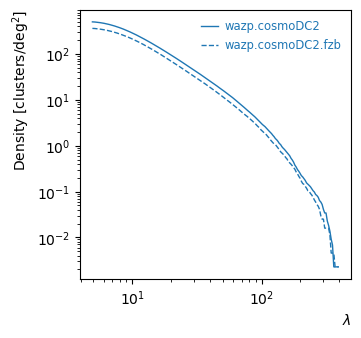

In [245]:
if not np.any([c[0] == 'cosmoDC2' for c in cats]) :
    fig = plt.subplots(1,1, figsize=(3.5,3.5));

    xs = np.logspace(0,3,300)
    xlabel = r'$\lambda$'
    ylabel = r'Density [clusters/deg$^2$]'

    fig[1].plot(xs[start_i[first]:last_i[first]], density[first][start_i[first]:last_i[first]], lw=1, c=colors[cats[first][0]], ls=linestyle[0], label=f"{'.'.join(cats[first][:-1])}");
    fig[1].plot(xs[start_i[last]:last_i[last]], density[last][start_i[last]:last_i[last]], lw=1, c=colors[cats[last][0]], ls=linestyle[1], label=f"{'.'.join(cats[last][:-1])}");
    fig[1].set_xscale('log');
    fig[1].set_yscale('log');
    fig[1].set_xlabel(xlabel, loc='right');
    fig[1].set_ylabel(ylabel, loc='top');
    if cats[0][0]==cats[1][0] :
        handlelength = 1.5
        handletextpad = 0.5
        visible = True
    else :
        handlelength = 0
        handletextpad = 0
        visible = False
    leg = fig[1].legend(labelcolor='mec', frameon=False, fontsize='small', loc='upper right', handlelength=handlelength, handletextpad=handletextpad)
    for item in leg.legendHandles :
        item.set_visible(visible)

### Completeness and Purity plots

In [186]:
zbins = np.linspace(0.2,1.1,12)
mbins = np.linspace(13,15,5)
richbins = np.linspace(0,3,5)

In [187]:
c1 = ClCatalog.read_full(inpath + '.'.join(cats[0]) + '.fits')
c2 = ClCatalog.read_full(inpath + '.'.join(cats[1]) + '.fits')

    * ClEvar used in matching: 0.14.1
    * ClEvar used in matching: 0.14.1


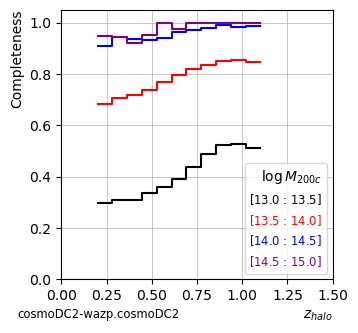

In [188]:
if np.any([c[0] == 'cosmoDC2' for c in cats]) :
    fig = plt.figure(figsize=(3.5,3.5));
    info = r_cf.plot(c1, col1='z', col2='log_mass', bins1=zbins, bins2=mbins, matching_type='cross', legend_format=lambda x: f'{x}', lines_kwargs_list = [{'color':'black'}, {'color':'red'}, {'color':'blue'}, {'color':'purple'}]);
    info['ax'].set_xlabel('$z_{halo}$', loc='right');
    info['ax'].set_ylabel('Completeness', loc='top');
    info['ax'].set_ylim(0,1.05);
    info['ax'].set_xlim(0,1.5);
    # plt.legend(loc='lower right', frameon=False);
    leg = plt.legend(labelcolor='mec', frameon=True, fontsize='small', title='$\log M_{200c}$', alignment='right', handlelength=0, handletextpad=0)
    for item in leg.legendHandles :
        item.set_visible(False)
    title=f"{'.'.join(cats[index][:-1])}-{'.'.join(cats[-(index+1)][:-1])}"
    fig.text(0,0, title, va='baseline', ha='left', size='small');

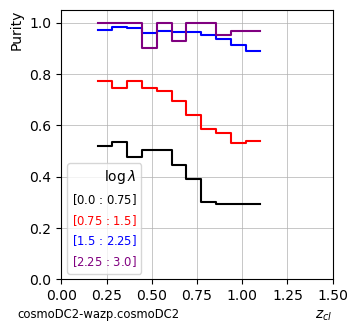

In [189]:
if np.any([c[0] == 'cosmoDC2' for c in cats]) :
    fig = plt.figure(figsize=(3.5,3.5));
    info = r_cf.plot(c2, col1='z', col2='mass', bins1=zbins, bins2=10**richbins, matching_type='cross', legend_format=lambda x: f'{np.log10(x)}', lines_kwargs_list = [{'color':'black'}, {'color':'red'}, {'color':'blue'}, {'color':'purple'}]);
    info['ax'].set_xlabel('$z_{cl}$', loc='right');
    info['ax'].set_ylabel('Purity', loc='top');
    info['ax'].set_ylim(0,1.05);
    info['ax'].set_xlim(0,1.5);
    # plt.legend(loc='lower right', frameon=False);
    leg = plt.legend(labelcolor='mec', frameon=True, fontsize='small', title='$\log \lambda$', alignment='right', handlelength=0, handletextpad=0)
    for item in leg.legendHandles :
        item.set_visible(False)
    title=f"{'.'.join(cats[index][:-1])}-{'.'.join(cats[-(index+1)][:-1])}"
    fig.text(0,0, title, va='baseline', ha='left', size='small');

<Figure size 640x480 with 0 Axes>

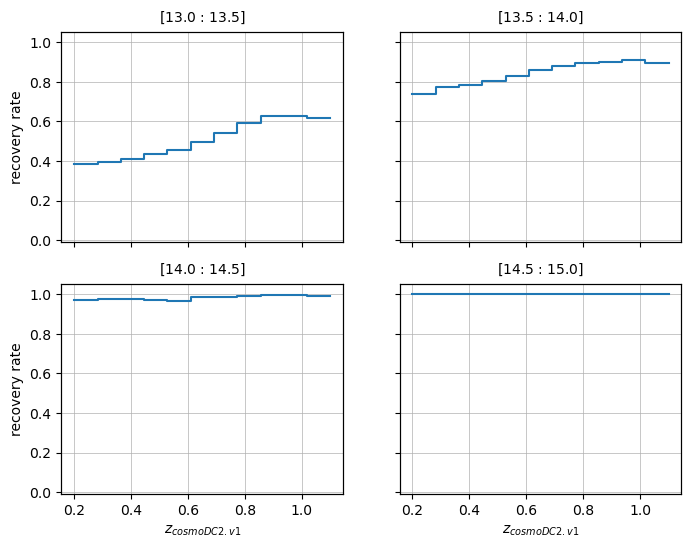

In [190]:
if np.any([c[0] == 'cosmoDC2' for c in cats]) :
    plt.figure();
    info = r_cf.plot_panel(c1, col1='z', col2='log_mass', bins1=zbins, bins2=mbins,
                           matching_type='multi_self', label_format=lambda x: f'{x}');

<Figure size 640x480 with 0 Axes>

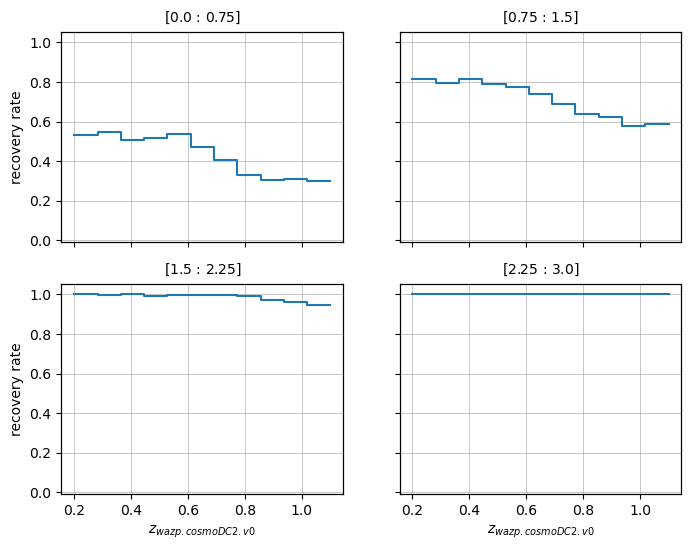

In [191]:
if np.any([c[0] == 'cosmoDC2' for c in cats]) :
    plt.figure();
    info = r_cf.plot_panel(c2, col1='z', col2='mass', bins1=zbins, bins2=10**richbins,
                           matching_type='multi_self', label_format=lambda x: f'{np.log10(x)}');

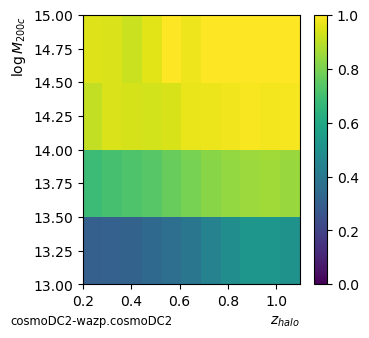

In [192]:
if np.any([c[0] == 'cosmoDC2' for c in cats]) :
    plt.figure(figsize=(3.5,3.5))
    info = r_cf.plot2D(c1, col1='z', col2='log_mass', bins1=zbins, bins2=mbins,
                       matching_type='cross')
    plt.xlabel("$z_{halo}$", loc='right');
    plt.ylabel("$\log M_{200c}$", loc='top');
    title=f"{'.'.join(cats[index][:-1])}-{'.'.join(cats[-(index+1)][:-1])}"
    plt.text(-0.1,12.7, title, va='baseline', ha='left', size='small');

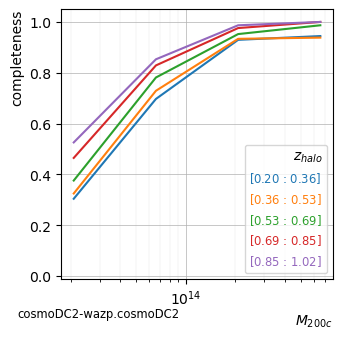

In [193]:
if np.any([c[0] == 'cosmoDC2' for c in cats]) :
    fig = plt.figure(figsize=(3.5,3.5))
    info = recovery.plot(c1, 'cross', zbins[::2], 10**mbins, shape='line', transpose=True)
    plt.xlabel('$M_{200c}$', loc='right');
    plt.ylabel('completeness', loc='top');
    leg = plt.legend(labelcolor='mec', frameon=True, fontsize='small', title='$z_{halo}$', alignment='right', handlelength=0, handletextpad=0)
    for item in leg.legendHandles :
        item.set_visible(False)
    title=f"{'.'.join(cats[index][:-1])}-{'.'.join(cats[-(index+1)][:-1])}"
    fig.text(0,0, title, va='baseline', ha='left', size='small');

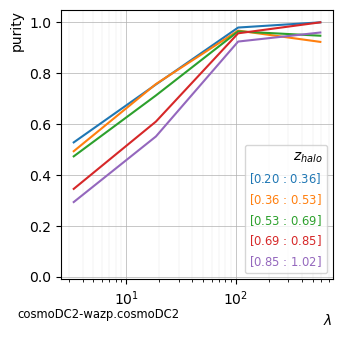

In [194]:
fig = plt.figure(figsize=(3.5,3.5))
info = recovery.plot(c2, 'cross', zbins[::2], 10**richbins, shape='line', transpose=True)
plt.xlabel('$\lambda$', loc='right');
plt.ylabel('purity', loc='top');
leg = plt.legend(labelcolor='mec', frameon=True, fontsize='small', title='$z_{halo}$', alignment='right', handlelength=0, handletextpad=0)
for item in leg.legendHandles :
    item.set_visible(False)
title=f"{'.'.join(cats[index][:-1])}-{'.'.join(cats[-(index+1)][:-1])}"
fig.text(0,0, title, va='baseline', ha='left', size='small');

In [283]:
info['data']

{'recovery': array([[0.52783505, 0.49308756, 0.47293233, 0.34492428, 0.29312977],
        [0.75559408, 0.75726044, 0.71242647, 0.60970399, 0.55114692],
        [0.97952218, 0.96742349, 0.96435644, 0.95684292, 0.92441583],
        [1.        , 0.92307692, 0.94736842, 1.        , 0.96      ]]),
 'edges1': array([   1.        ,    5.62341325,   31.6227766 ,  177.827941  ,
        1000.        ]),
 'edges2': array([0.2       , 0.36363636, 0.52727273, 0.69090909, 0.85454545,
        1.01818182]),
 'matched': array([[  256,   428,   629,   615,   384],
        [ 4795,  9752, 15382, 21689, 23739],
        [  574,   980,  1461,  2461,  3877],
        [   12,    12,    18,    27,    48]]),
 'counts': array([[  485,   868,  1330,  1783,  1310],
        [ 6346, 12878, 21591, 35573, 43072],
        [  586,  1013,  1515,  2572,  4194],
        [   12,    13,    19,    27,    50]])}